# COGS 108 - Data Checkpoint

# Names

- Maxwell Fang
- Long Le
- Huy Trinh
- Hasan Shaikh
- Mohammed Master

<a id='research_question'></a>
# Research Question

How does the spice level of instant ramen affect the star rating on the www.theramenrater.com in regards to preference across each country?

# Dataset(s)

*Fill in your dataset information here*

(Copy this information for each dataset)
- Dataset Name: Top Ramen Ratings 2022
- Link to the dataset: https://www.kaggle.com/datasets/ankanhore545/top-ramen-ratings-2022
- Number of observations: 4120

1-2 sentences describing each dataset. 

If you plan to use multiple datasets, add 1-2 sentences about how you plan to combine these datasets.

# Setup

In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from category_dict import spiciness_dict
import re

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [2]:
## YOUR CODE HERE
ramen = pd.read_csv('ramen_rating.csv')
ramen.head()

,Review #,Brand,Variety,Style,Country,Stars,T
0,4120,MIT,Shallot Sauce Dry Noodle,Pack,Taiwan,3,NaN
1,4119,Sapporo Ichiban,Tonkotsu Ramen Japanese Style Noodles,Bowl,United States,4.5,NaN
2,4118,Binh Tay,Mi Kiwi,Bowl,Vietnam,3,NaN
3,4117,Charming Couple,Biang Biang Scallion Chicken Sauce,Pack,Taiwan,4.5,NaN
4,4116,immi,Tom Yum Shrimp Flavor Ramen Soup,Pack,United States,2.75,NaN


# Data Cleaning

First, we want to only keep the columns that are necessary for our analysis. Columns such as `Review #` and `T` are not needed for this analysis. Because of that reason, we are removing those columns from our analysis.

In [3]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION
df = ramen.drop(columns=['T','Review #'])
df.head()

,Brand,Variety,Style,Country,Stars
0,MIT,Shallot Sauce Dry Noodle,Pack,Taiwan,3
1,Sapporo Ichiban,Tonkotsu Ramen Japanese Style Noodles,Bowl,United States,4.5
2,Binh Tay,Mi Kiwi,Bowl,Vietnam,3
3,Charming Couple,Biang Biang Scallion Chicken Sauce,Pack,Taiwan,4.5
4,immi,Tom Yum Shrimp Flavor Ramen Soup,Pack,United States,2.75


## Feature Engineering
We want to add the spiciness column from extracting the text from `Variety` column. First, we want to see if `mild`, `medium`, `spicy`, `hot`, or `fiery` is in the text itself. If any of those words is in the text, we would use the according spiciness scale to categorize the group.

In [4]:
spicy_levels = ['mild','medium','spicy','hot','fiery']
def spiciness(text):
    text= text.lower()
    for spice in spicy_levels:
        if spice in text:
            return spice
    return 'pepper free'

df['spiciness'] = df['Variety'].apply(spiciness)
df.head()

,Brand,Variety,Style,Country,Stars,spiciness
0,MIT,Shallot Sauce Dry Noodle,Pack,Taiwan,3,pepper free
1,Sapporo Ichiban,Tonkotsu Ramen Japanese Style Noodles,Bowl,United States,4.5,pepper free
2,Binh Tay,Mi Kiwi,Bowl,Vietnam,3,pepper free
3,Charming Couple,Biang Biang Scallion Chicken Sauce,Pack,Taiwan,4.5,pepper free
4,immi,Tom Yum Shrimp Flavor Ramen Soup,Pack,United States,2.75,pepper free


In [5]:
df.spiciness.value_counts()

pepper free    3523
spicy           446
hot             128
mild             21
fiery             2
Name: spiciness, dtype: int64

With this simple text extraction, we are able to correctly categorize almost 600 of these instant ramens. Next, we want to use the popular phrases in the variety text to manually categorize those phrases. Every phrase is made up from splitting up the string in the column `Variety` to pairs of words. Then, we loop through instant noodle name to count the occurence of these phrases.

In [6]:
# extracting spiciness from text
# cleaning the string from the Variety column
variety_list = (df['Variety'].str.lower()
                .str.replace('[^a-zA-Z]', ' ', regex=True)
                .str.replace(' +', ' ', regex=True).values)

# finding the most popular phrases to catagorize
pairs_dict = {}
for i in variety_list:
    words = i.split()
    for j in range(len(words) - 1):
        pair = words[j] + ' ' + words[j+1]
        if pair in pairs_dict:
            pairs_dict[pair] += 1
        else:
            pairs_dict[pair] = 1
            
# only take the popular phrase if it appears more than 10 times
popular_phrases = [(i, pairs_dict[i]) for i in pairs_dict if pairs_dict[i] > 10]
popular_phrases.sort(key=lambda x: x[1],reverse = True)
popular_phrases[:6] 

[('instant noodles', 298),
 ('noodle soup', 178),
 ('cup noodles', 161),
 ('instant noodle', 134),
 ('tom yum', 117),
 ('chicken flavor', 104)]

From these most used phrases, phrases such as `'instant noodles'` or `'noodle soup'` or `'cup noodles'` are not informative. Because of that reason, we cannot use these uninformative phrases to categorize the spiciness. On the other hand, we can use phrases like `'tom yum'` and `'chicken flavor'` to categorize their spiciness level. We include our categorization in the `category_dict.py` file in the same directory as this Jupyter Notebook.

Then, we loop through the every row to find if the `Variety` column contains any of the pairs that we previously categorized. If the phrase exists in its packaging name, we categorize it with its approriate spiciness.

In [7]:
spicy_levels = ['mild','medium','spicy','hot']
def spiciness(text):
    # catch if the spciniess is directly in the text
    text = re.sub('r[^a-zA-Z]', ' ', text.lower())
    text = re.sub(' +', ' ', text)
    for spice in spicy_levels:
        if spice in text:
            return spice
    
    # catch if the spiciness is implied in the text 
    words = text.split()
    for j in range(len(words) - 1):
        pair = words[j] + ' ' + words[j+1]
        if pair in spiciness_dict:
            return spiciness_dict[pair]
    return 'pepper free'


df['spiciness_2'] = df['Variety'].apply(spiciness)
df['spiciness_2'].value_counts()

pepper free    2834
mild            526
spicy           446
hot             314
Name: spiciness_2, dtype: int64

After using engineering the feature using this process, we are able to categorize up to almost 1300 noodles.

In [8]:
spicy_levels = ['mild','medium','spicy','hot']
#0 is non-pepper, 
#(100, 2500) is mild
#(500, 2500) is medium
#(2500, 10000) is spicy
#(10000, 50000) is hot
#units: Scoville heat units
scoville_levels = [0, (100, 500), (500, 2500), (2500, 10000), (10000, 50000)]

def calc_scoville_level(level):
    if level == 'non-pepper':
        return scoville_levels[0]
    elif level == 'mild':
        return scoville_levels[1]
    elif level == 'medium':
        return scoville_levels[2]
    elif level == 'spicy':
        return scoville_levels[3]
    else:
        return scoville_levels[4]
    
df['Scoville'] = df['spiciness_2'].apply(calc_scoville_level)
df['Scoville'].value_counts()

(10000, 50000)    3148
(100, 500)         526
(2500, 10000)      446
Name: Scoville, dtype: int64

# separate by region

'https://worldpopulationreview.com/country-rankings/list-of-countries-by-continent'

In [9]:
continent = pd.read_csv('country_by_continent.csv')
continent['country'] = continent['country'].str.lower().str.replace(' ','')
df['country'] =  df['Country'].str.lower().str.replace(' ','')
continent

,country,continent
0,algeria,Africa
1,angola,Africa
2,benin,Africa
3,botswana,Africa
4,burkinafaso,Africa
...,...,...
229,paraguay,South America
230,peru,South America
231,suriname,South America
232,uruguay,South America


In [10]:
new_df = pd.merge(df, continent, on="country")
new_df = new_df.drop(columns=['country'])
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4027 entries, 0 to 4026
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Brand        4027 non-null   object
 1   Variety      4027 non-null   object
 2   Style        4027 non-null   object
 3   Country      4027 non-null   object
 4   Stars        4027 non-null   object
 5   spiciness    4027 non-null   object
 6   spiciness_2  4027 non-null   object
 7   Scoville     4027 non-null   object
 8   continent    4027 non-null   object
dtypes: object(9)
memory usage: 314.6+ KB


In [11]:
star_values = ['1', '1.25', '1.5', '1.75', '2', '2.25', '2.5', '2.75', '3', '3.25', '3.5', '3.75', '4', '4.25', 
                   '4.5', '4.75', '5']
new_df = new_df[new_df.Stars.isin(star_values) == True]
def star_converted(s):
  rating = s.split('/')[0]
  try:
      return float(rating)
  except ValueError:
      return None

In [12]:
new_df.Stars= new_df.Stars.apply(star_converted)
star_count = new_df['Stars'].value_counts()
star_count
new_df

,Brand,Variety,Style,Country,Stars,spiciness,spiciness_2,Scoville,continent
0,MIT,Shallot Sauce Dry Noodle,Pack,Taiwan,3.00,pepper free,pepper free,"(10000, 50000)",Asia
1,Charming Couple,Biang Biang Scallion Chicken Sauce,Pack,Taiwan,4.50,pepper free,pepper free,"(10000, 50000)",Asia
2,Hi Lai Foods,Lai Noodle Vegan Sesame Paste Flavor,Pack,Taiwan,5.00,pepper free,pepper free,"(10000, 50000)",Asia
3,Ve Wong,Artificial Peppered Beef Flavor,Pack,Taiwan,3.50,pepper free,mild,"(100, 500)",Asia
4,iNoodle,Flat Noodle Soy Sauce Flavor,Pack,Taiwan,3.25,pepper free,mild,"(100, 500)",Asia
...,...,...,...,...,...,...,...,...,...
4022,Nissin,Sabor A Pollo Sopa Instantánea Con Fideos,Pack,Colombia,3.25,pepper free,pepper free,"(10000, 50000)",South America
4023,Nissin,Cup Noodles Sabor A Gallina,Cup,Colombia,3.50,pepper free,pepper free,"(10000, 50000)",South America
4024,Nissin,Sabor A Carne Sopa Instantánea Con Fideos,Pack,Colombia,3.75,pepper free,pepper free,"(10000, 50000)",South America
4025,Baltix,Instant Noodles With Chicken Flavour Broth,Pack,Estonia,3.75,pepper free,pepper free,"(10000, 50000)",Europe


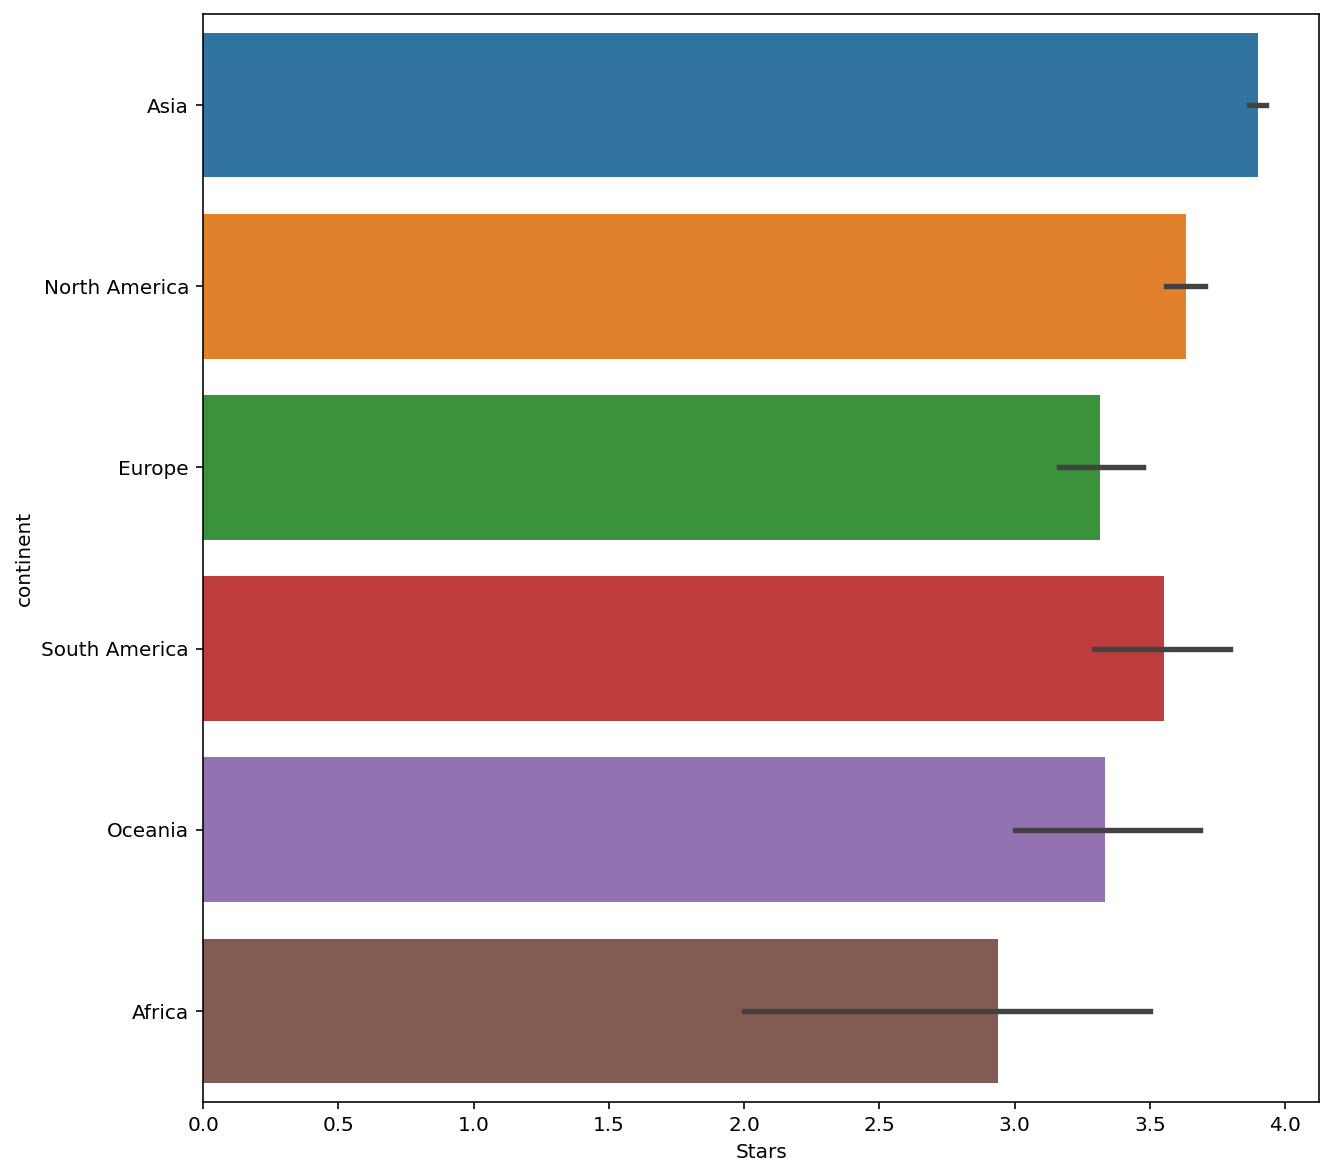

In [13]:
plt.figure(figsize = (10, 10))
barplot = sns.barplot(data = new_df, x = 'Stars', y = 'continent')
#scatterplot.set_xticks(range(17))
#scatterplot.set_xticklabels(values)

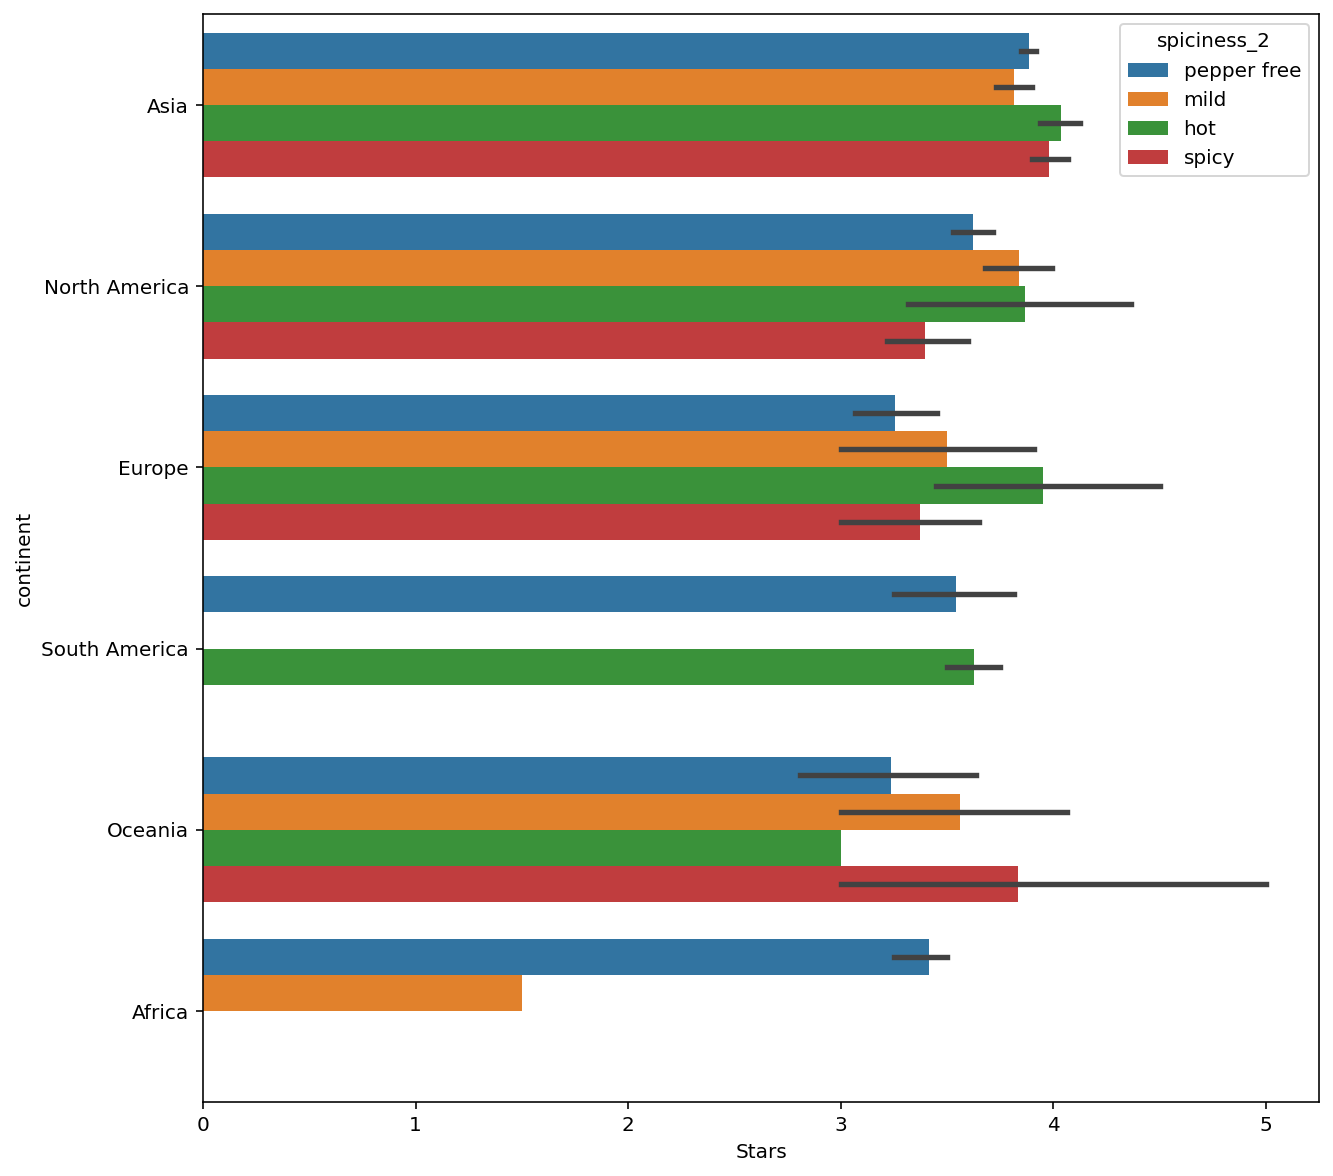

In [15]:
plt.figure(figsize = (10, 10))
barplot = sns.barplot(data = new_df, x = 'Stars', y = 'continent', hue = 'spiciness_2')